In [1]:
!pip install torch matplotlib numpy argparse Pillow torchvision scikit-image tqdm h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 39.7 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 79.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 14.1 MB/s eta 0:00:00


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from PIL import Image
import json
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transformsZ
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
import argparse
from PIL import Image
from imageio import imread
from skimage.transform import resize
from PIL import Image
import os
import urllib.request
import zipfile
import os
import numpy as np
import h5py
import json
import torch
from PIL import Image
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample
from skimage.transform import resize


In [3]:
# Set the URLs for downloading the dataset
dataset_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
annotations_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

# Set the paths for saving the dataset
dataset_save_path = "/Flickr8k_Dataset.zip"
annotations_save_path = "/Flickr8k.zip"

# Download the dataset and annotations
urllib.request.urlretrieve(dataset_url, dataset_save_path)
urllib.request.urlretrieve(annotations_url, annotations_save_path)

# Unzip the dataset
with zipfile.ZipFile(dataset_save_path, "r") as zip_ref:
    zip_ref.extractall("/Flickr8k_Dataset")

# Unzip the annotations
with zipfile.ZipFile(annotations_save_path, "r") as zip_ref:
    zip_ref.extractall("/Flickr8k_text")

# Remove the zip files
os.remove(dataset_save_path)
os.remove(annotations_save_path)


In [4]:
!git clone https://github.com/dwayne99/Image_Captioning.git

Cloning into 'Image_Captioning'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 40 (delta 15), reused 23 (delta 4), pack-reused 0
Unpacking objects: 100% (40/40), 2.03 MiB | 5.41 MiB/s, done.


In [5]:
# Dependancies
import json
from collections import Counter
from random import seed, choice, sample
import h5py
from tqdm import tqdm
import cv2
from cv2 import imread, resize
import os
import numpy as np


def create_input_files(dataset, json_path, image_folder, captions_per_image,
                       min_word_freq, output_folder, max_len = 100):

    '''
    Creates input files for training, validation, and test data.
    :param dataset: name of dataset, one of 'coco', 'flickr8k', 'flickr30k'
    :param json_path: path of Karpathy JSON file with splits and captions
    :param image_folder: folder with downloaded images
    :param captions_per_image: number of captions to sample per image
    :param min_word_freq: words occuring less frequently than this threshold are binned as <unk>s
    :param output_folder: folder to save files
    :param max_len: don't sample captions longer than this length
    '''

    assert dataset in {'coco', 'flickr8k', 'flickr30k'}

    # Read Karpathy JSON
    with open(json_path, 'r') as j:
        data = json.load(j)

    # Read image paths and captions for each image
    train_image_paths = []
    train_image_captions = []
    val_image_paths = []
    val_image_captions = []
    test_image_paths = []
    test_image_captions = []
    word_freq = Counter()

    # iterate over data
    for img in data['images']:
        captions = []

        # iterate over each caption of an image
        for c in img['sentences']:

            # update word frequency
            word_freq.update(c['tokens'])
            
            # don't save caption that exceeds max_len
            if len(c['tokens']) <= max_len:
                captions.append(c['tokens'])

        # if all captions of an image don't meet max_len criteria don't save the image
        if len(captions) == 0:
            continue

        # construct the image path
        path = os.path.join(image_folder, img['filename'])

        # Check the value of the split attribute to place image in the desired folder
        if img['split'] in {'train', 'restval'}:
            train_image_paths.append(path)
            train_image_captions.append(captions)
        elif img['split'] in {'val'}:
            val_image_paths.append(path)
            val_image_captions.append(captions)
        elif img['split'] in {'test'}:
            test_image_paths.append(path)
            test_image_captions.append(captions)
            

    # Sanity check
    assert len(train_image_paths) == len(train_image_captions)
    assert len(val_image_paths) == len(val_image_captions)
    assert len(test_image_paths) == len(test_image_captions)

    # Create the word map

    # shortlist the words that meet min_word_freq criteria
    words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
    word_map = {k: v for v, k in enumerate(words,1)}
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0

    # Create a base/root name for all output files
    base_filename = dataset + '_' + str(captions_per_image) + '_cap_per_img_' + str(min_word_freq) + '_min_word_freq'

    # Save word map to a JSON
    with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
        json.dump(word_map, j)

    # Sample captions for each image, save images to HDF5 file, and captions along with their lengths to JSON files
    seed(123)

    for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                   (val_image_paths, val_image_captions, 'VAL'),
                                   (test_image_paths, test_image_captions, 'TEST')]:

        with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:
            # Make a note of the num of captions we're sampling per image
            h.attrs['captions_per_image'] = captions_per_image

            # Create a dataset inside HDF5 file to store images
            images = h.create_dataset('Images', (len(impaths), 3, 256, 256), dtype='uint8')

            print("\nReading %s images and captions, storing to file...\n" % split)

            enc_captions = []
            caplens = []

            for i, path in enumerate(tqdm(impaths)):

                # Sample captions 
                if len(imcaps[i]) < captions_per_image:
                    captions = imcaps[i] + [choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
                else:
                    captions = sample(imcaps[i], k=captions_per_image)

                # Sanity check
                assert len(captions) == captions_per_image

                # Read images
                img = imread(impaths[i])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # if image is grayscale add the depth dimention to it
                if len(img.shape) == 2 :
                    img = img[:,:, np.newaxis]
                    img = np.concatenate([img, img, img], axis=2)
                # Resize the image 
                img = resize(img, (256,256))
                # convert image from H x W x C -->  C x H x W
                img = img.transpose(2,0,1)

                assert img.shape == (3, 256, 256)
                assert np.max(img) <= 255

                # Save image to HDF5 file
                images[i] = img

                for j, c in enumerate(captions):
                    # Encode captions
                    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c] + [
                        word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c))

                    # Find caption lengths, add 2 for 'start' and 'end' tokens
                    c_len = len(c) + 2

                    enc_captions.append(enc_c)
                    caplens.append(c_len)

            # Sanity check
            assert images.shape[0] * captions_per_image == len(enc_captions) == len(caplens)

            # Save encoded captions and their lengths to JSON files
            with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
                json.dump(enc_captions, j)

            with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
                json.dump(caplens, j)

In [6]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.3 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 14.5 MB/s eta 0:00:00


In [7]:
create_input_files(
        dataset='flickr8k',
        json_path = 'Image_Captioning/data/dataset_flickr8k.json',
        image_folder='Flickr8k_Dataset/Flicker8k_Dataset',
        captions_per_image=5,
        min_word_freq=5,
        output_folder='/',
        max_len=50
)


Reading TRAIN images and captions, storing to file...



100%|██████████| 6000/6000 [00:25<00:00, 234.76it/s]



Reading VAL images and captions, storing to file...



100%|██████████| 1000/1000 [00:04<00:00, 234.37it/s]



Reading TEST images and captions, storing to file...



100%|██████████| 1000/1000 [00:04<00:00, 234.37it/s]


In [8]:
import torch
from torch import nn
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Encoder(nn.Module):
    '''Encoder Model'''

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        # pretrained ImageNet ResNeXt-101
        resnext = torchvision.models.resnext101_32x8d(pretrained=True)

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnext.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize the image to a fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        '''
        Forward propagation
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        '''

        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        '''
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Allow?
        '''

        for p in self.resnet.parameters():
            p.requires_grad = False

        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

    
class Attention(nn.Module):
    '''Attention Network'''

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        # linear layer to transform encoded image
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  
        # linear layer to transform decoder's output
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        # linear layer to calculate values to be softmax-ed
        self.full_att = nn.Linear(attention_dim,1) 
        self.relu = nn.ReLU()
        # softmax layer to calculate weights
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden) # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att) # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        
        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    '''Decoder'''
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        '''
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of the vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        '''
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim  #2048
        self.attention_dim = attention_dim   #512
        self.embed_dim = embed_dim  #512
        self.decoder_dim = decoder_dim  # 512
        self.vocab_size = vocab_size
        self.dropout = dropout

        # Create an Attention Network Instance
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embed_dim) 
        # Dropout Layer 
        self.dropout = nn.Dropout(p = self.dropout)
        # Decoding LSTM
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim,bias=True)
        # linear layer to find initial hidden state of LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        # linear layer to find initial cell state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        # linear layer to create a sigmoid activated gate
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        # linear layer to find scores over vocab
        self.fc = nn.Linear(decoder_dim, vocab_size)
        # initialize some layers with the uniform distribution
        self.init_weights()


    def init_weights(self):
        '''
        Initializes some parameters with values from the uniform distribution, for easier convergence
        '''
        self.embedding.weight.data.uniform_(-0.1,0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)


    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.
        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)


    def fine_tune_embeddigs(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    
    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        # mean_encoder_out = [batch_size, encoder_dim]
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)  
        return h, c


    def forward(self, encoder_out, encoded_captions ,caption_lengths):
        '''
        Forward Propagation

        :param encoder_out: encoded images, a tensor of dimention (batch_size,enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions,  a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        '''

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1) # 2048
        vocab_size = self.vocab_size

        # encoder_out.shape = (batch_size, 14,14,2048)
        # Flatten the image:  
        encoder_out= encoder_out.view(batch_size, -1, encoder_dim)
        # encoder_out.shape = (batch_size, 14*14,2048)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths:
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        # caption_lengths = sorted([batch_size]), sort_ind = [batch_size]
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions) 
        # embedding.shape = [batch_size, max_caption_length, embed_dim]

        # Initialize the LSTM state
        h, c = self.init_hidden_state(encoder_out) # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # so, decoding lengths are actual lengths-1
        decode_lengths = (caption_lengths -1 ).tolist()
        # decode_lengths = [batch_size]

        # create tensors to hold word prediction scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by 
        # attention-weighing the encoder's output based on the decoder's based on the decoders previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([ l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])

            gate = self.sigmoid(self.f_beta(h[:batch_size_t])) # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)

            preds = self.fc(self.dropout(h)) # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [9]:
import torch

##########################################################FUNCTIONS FOR TRAIN.PY
def adjust_learning_rate(optimizer, shrink_factor):
    '''
    Shrinks the learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be shrunk
    :param shrink_factor: factor in interval (0,1) to multiply learning rate with
    '''

    print('\nDECAYING learning rate.')
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr']*shrink_factor
    print('The new learning rate is %f\n' %(optimizer.param_groups[0]['lr'],))


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """
    def __init__(self):
        self.resnet()

    def resnet(self):
        self.val = 0
        self.avg = 0
        self.sum_ = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum_ += val*n
        self.count +=  n
        self.avg = self.sum_ / self.count
        

def clip_gradient(optimizer, grad_clip):
    '''
    clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    '''

    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def accuracy(scores, targets, k):
    '''
    computes the top-k accuracy, from predicted and true labels.

    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    '''

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

    
def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.
    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, 'BEST_' + filename)







In [10]:
# Dependancies
import torch
from torch.utils.data import Dataset
import h5py
import json
import os


class CaptionDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, data_name, split, transform=None):
        """
        :param data_folder: folder where data files are stored
        :param data_name: base name of processed datasets
        :param split: split, one of 'TRAIN', 'VAL', or 'TEST'
        :param transform: image transform pipeline
        """
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        # Open hdf5 file where images are stored
        self.h = h5py.File(os.path.join(data_folder, self.split +  '_IMAGES_' + data_name + '.hdf5'), 'r')
        self.imgs = self.h['Images']

        # captions per image 
        self.cpi = self.h.attrs['captions_per_image']

        # Load encoded captions (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPTIONS_' + data_name + '.json'), 'r') as j:
            self.captions = json.load(j)

        # Load caption lengths (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPLENS_' + data_name + '.json'), 'r') as j:
            self.caplens = json.load(j)

        # PyTorch transformation pipeline for the image (normalizing, etc.)
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.captions)


    def __getitem__(self, i):
        # Remember, the Nth caption corresponds to the ( N // captions_per_image)th image
        img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
        
        # Apply the transform to the image
        if self.transform is not None:
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])
        
        caplen = torch.LongTensor([self.caplens[i]])

        if self.split is 'TRAIN':
            return img, caption, caplen

        else:
            # For validation of testing, also return all 'captions_per_image' captions to find BLEU-4 score
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions


    def __len__(self):
        return self.dataset_size

<>:58: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:58: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_2320/1137577698.py:58: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.split is 'TRAIN':


In [15]:
import time
import torch.backends.cudnn as cudnn
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence

from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm



def main():
    '''Training and Validation'''

    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

    # Read word map
    word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)


    # Initialize or load checkpoint
    if checkpoint is None:
        decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(word_map),
                                       dropout=dropout)
        
        decoder_optimizer = torch.optim.Adam(params = filter(lambda p: p.requires_grad, decoder.parameters()),lr=decoder_lr)

        encoder = Encoder()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

    else:
        # Loading the checkpoint
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['blue-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                 lr=encoder_lr)

    # Move to GPU, if available
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # Custom DataLoaders
    # normalizing with args most suited for Resnet-101, check torchvision docs for more info.
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std =[0.229, 0.224, 0.225])

    train_loader = DataLoader(
        # Custom dataset
        CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True
    ) #If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory.

    val_loader = DataLoader(
        CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    print(f'Training on {device}')

    for epoch in range(start_epoch, epochs):

        # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            # if encoder is being trained too then change its lr
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        # One epoch's training
        train(
            train_loader=train_loader,
            encoder = encoder,
            decoder = decoder,
            criterion = criterion,
            encoder_optimizer = encoder_optimizer,
            decoder_optimizer = decoder_optimizer,
            epoch = epoch
        )

        # One epoch's validation
        recent_bleu4 = validate(
            val_loader=val_loader,
            encoder=encoder,
            decoder=decoder,
            criterion=criterion
        )

        # Check if there was an improvement
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        # save checkpoint
        save_checkpoint(data_name,epoch,epochs_since_improvement,encoder,decoder,encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)


def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    '''
    Performs one epoch of training

    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param  encoder_optimizer: optimizer to update encoder's weights ( if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number 
    '''

    # Set both the models to train mode: This will enable all dropouts and batch_norm layers
    decoder.train()
    encoder.train()

    batch_time = AverageMeter() #forward prop + back prop time
    data_time  = AverageMeter() # data loading time
    losses = AverageMeter() # loss (per word decoded)
    top5accs = AverageMeter() # top 5 accuracy

    start = time.time()

    # Batches 
    for i, (imgs, caps, caplens) in tqdm(enumerate(train_loader)):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        # imgs.size() = [batch_size, C, H, W] == [32,3,256,256]
        imgs = imgs.to(device)
        # caps.size() = [batch_size, max_caption_len] == [32,100] 
        caps = caps.to(device)
        # caplens.size() = [batch_size, 1] == [32,1] 
        caplens = caplens.to(device)

        # Forward prop
        imgs = encoder(imgs)
        # imgs.size() = [batch_size, 14,14,2048]

        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at or are pads
        # pack_padded_sequence is an easy trick to do this
        scores = pack_padded_sequence(scores, decode_lengths, batch_first = True)
        scores = scores.data
        targets= pack_padded_sequence(targets, decode_lengths, batch_first=True)
        targets = targets.data

        # Calculate the loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c*((1.-alphas.sum(dim=1)**2)).mean()

        # Back prop
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                  data_time=data_time, loss=losses,
                                                                          top5=top5accs))

def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in tqdm(enumerate(val_loader)):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            scores = scores.data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)
            targets = targets.data

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            sort_ind = sort_ind.cpu()
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder 
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypothesis
            _, preds = torch.max(scores_copy, dim = 2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))

        # Calculate BLEU-2 score
        bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))

        # Calculate BLEU-3 score
        bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))

        # Calculate BLEU-4 score
        bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-1 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu1))
        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-2 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu2))
        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-3 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu3))
        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4



            

In [14]:
# Data parameters
data_folder = '/'  # folder with data files saved by create_input_files.py
data_name = 'flickr8k_5_cap_per_img_5_min_word_freq'   # base name shared by data files

# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Training parameters
start_epoch = 0
epochs = 120  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 512
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 59  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder

# BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar
checkpoint = None  # path to checkpoint, None if none


In [16]:
main()


Training on cuda


1it [00:02,  2.75s/it]

Epoch: [0][0/59]	Batch Time 2.817 (2.817)	Data Load Time 0.799 (0.799)	Loss 8.9447 (8.9447)	Top-5 Accuracy 0.067 (0.067)


59it [01:59,  2.02s/it]
1it [00:02,  2.84s/it]

Validation: [0/10]	Batch Time 2.806 (2.806)	Loss 6.0760 (6.0760)	Top-5 Accuracy 40.355 (40.355)	


10it [00:21,  2.20s/it]



 * LOSS - 6.094, TOP-5 ACCURACY - 40.070, BLEU-1 - 0.39508677789888486


 * LOSS - 6.094, TOP-5 ACCURACY - 40.070, BLEU-2 - 0.1805321495317555


 * LOSS - 6.094, TOP-5 ACCURACY - 40.070, BLEU-3 - 0.0827779537885309


 * LOSS - 6.094, TOP-5 ACCURACY - 40.070, BLEU-4 - 0.04325199998374332



1it [00:02,  2.93s/it]

Epoch: [1][0/59]	Batch Time 2.984 (2.984)	Data Load Time 0.769 (0.769)	Loss 5.2497 (5.2497)	Top-5 Accuracy 38.667 (38.667)


59it [01:57,  2.00s/it]
1it [00:02,  2.64s/it]

Validation: [0/10]	Batch Time 2.658 (2.658)	Loss 5.7331 (5.7331)	Top-5 Accuracy 50.370 (50.370)	


10it [00:17,  1.70s/it]



 * LOSS - 5.735, TOP-5 ACCURACY - 49.771, BLEU-1 - 0.5167435230988513


 * LOSS - 5.735, TOP-5 ACCURACY - 49.771, BLEU-2 - 0.2761876362049238


 * LOSS - 5.735, TOP-5 ACCURACY - 49.771, BLEU-3 - 0.1288768250741049


 * LOSS - 5.735, TOP-5 ACCURACY - 49.771, BLEU-4 - 0.06033308561417087



1it [00:02,  2.92s/it]

Epoch: [2][0/59]	Batch Time 2.999 (2.999)	Data Load Time 0.800 (0.800)	Loss 4.4916 (4.4916)	Top-5 Accuracy 48.754 (48.754)


59it [01:57,  2.00s/it]
1it [00:02,  2.63s/it]

Validation: [0/10]	Batch Time 2.653 (2.653)	Loss 5.4160 (5.4160)	Top-5 Accuracy 53.867 (53.867)	


10it [00:17,  1.71s/it]



 * LOSS - 5.395, TOP-5 ACCURACY - 54.538, BLEU-1 - 0.5667477152678796


 * LOSS - 5.395, TOP-5 ACCURACY - 54.538, BLEU-2 - 0.31778060917773937


 * LOSS - 5.395, TOP-5 ACCURACY - 54.538, BLEU-3 - 0.15858797063762703


 * LOSS - 5.395, TOP-5 ACCURACY - 54.538, BLEU-4 - 0.07741409441402501



1it [00:02,  2.69s/it]

Epoch: [3][0/59]	Batch Time 2.759 (2.759)	Data Load Time 0.794 (0.794)	Loss 4.1749 (4.1749)	Top-5 Accuracy 52.906 (52.906)


59it [01:58,  2.01s/it]
1it [00:02,  2.65s/it]

Validation: [0/10]	Batch Time 2.654 (2.654)	Loss 5.2679 (5.2679)	Top-5 Accuracy 56.595 (56.595)	


10it [00:17,  1.72s/it]



 * LOSS - 5.197, TOP-5 ACCURACY - 57.394, BLEU-1 - 0.5848411167938291


 * LOSS - 5.197, TOP-5 ACCURACY - 57.394, BLEU-2 - 0.3393037679843587


 * LOSS - 5.197, TOP-5 ACCURACY - 57.394, BLEU-3 - 0.17997398245143215


 * LOSS - 5.197, TOP-5 ACCURACY - 57.394, BLEU-4 - 0.09371114051122051



1it [00:02,  2.98s/it]

Epoch: [4][0/59]	Batch Time 3.041 (3.041)	Data Load Time 0.787 (0.787)	Loss 3.8012 (3.8012)	Top-5 Accuracy 57.510 (57.510)


59it [01:57,  2.00s/it]
1it [00:02,  2.59s/it]

Validation: [0/10]	Batch Time 2.614 (2.614)	Loss 5.0095 (5.0095)	Top-5 Accuracy 59.352 (59.352)	


10it [00:17,  1.73s/it]



 * LOSS - 5.063, TOP-5 ACCURACY - 59.443, BLEU-1 - 0.6077135910119896


 * LOSS - 5.063, TOP-5 ACCURACY - 59.443, BLEU-2 - 0.36105869380568084


 * LOSS - 5.063, TOP-5 ACCURACY - 59.443, BLEU-3 - 0.20113198646103264


 * LOSS - 5.063, TOP-5 ACCURACY - 59.443, BLEU-4 - 0.10953464740291444



1it [00:02,  2.86s/it]

Epoch: [5][0/59]	Batch Time 2.920 (2.920)	Data Load Time 0.762 (0.762)	Loss 3.6465 (3.6465)	Top-5 Accuracy 59.980 (59.980)


59it [01:57,  2.00s/it]
1it [00:02,  2.73s/it]

Validation: [0/10]	Batch Time 2.743 (2.743)	Loss 4.9185 (4.9185)	Top-5 Accuracy 60.509 (60.509)	


10it [00:17,  1.72s/it]



 * LOSS - 4.958, TOP-5 ACCURACY - 60.743, BLEU-1 - 0.6174561918336547


 * LOSS - 4.958, TOP-5 ACCURACY - 60.743, BLEU-2 - 0.37708776522012083


 * LOSS - 4.958, TOP-5 ACCURACY - 60.743, BLEU-3 - 0.21374487176389867


 * LOSS - 4.958, TOP-5 ACCURACY - 60.743, BLEU-4 - 0.11854867301231792



1it [00:02,  2.99s/it]

Epoch: [6][0/59]	Batch Time 3.045 (3.045)	Data Load Time 0.783 (0.783)	Loss 3.4370 (3.4370)	Top-5 Accuracy 61.955 (61.955)


59it [01:58,  2.00s/it]
1it [00:02,  2.58s/it]

Validation: [0/10]	Batch Time 2.619 (2.619)	Loss 4.8165 (4.8165)	Top-5 Accuracy 62.920 (62.920)	


10it [00:16,  1.69s/it]



 * LOSS - 4.882, TOP-5 ACCURACY - 61.960, BLEU-1 - 0.6194516642911042


 * LOSS - 4.882, TOP-5 ACCURACY - 61.960, BLEU-2 - 0.3789552954501184


 * LOSS - 4.882, TOP-5 ACCURACY - 61.960, BLEU-3 - 0.21717034904700433


 * LOSS - 4.882, TOP-5 ACCURACY - 61.960, BLEU-4 - 0.12277205647322754



1it [00:02,  2.89s/it]

Epoch: [7][0/59]	Batch Time 2.958 (2.958)	Data Load Time 0.780 (0.780)	Loss 3.3625 (3.3625)	Top-5 Accuracy 63.343 (63.343)


59it [01:57,  2.00s/it]
1it [00:02,  2.64s/it]

Validation: [0/10]	Batch Time 2.654 (2.654)	Loss 4.8507 (4.8507)	Top-5 Accuracy 62.980 (62.980)	


10it [00:17,  1.71s/it]



 * LOSS - 4.827, TOP-5 ACCURACY - 62.738, BLEU-1 - 0.6189653726838266


 * LOSS - 4.827, TOP-5 ACCURACY - 62.738, BLEU-2 - 0.37991148001049174


 * LOSS - 4.827, TOP-5 ACCURACY - 62.738, BLEU-3 - 0.21791346190793853


 * LOSS - 4.827, TOP-5 ACCURACY - 62.738, BLEU-4 - 0.12270258651519617


Epochs since last improvement: 1



1it [00:02,  2.92s/it]

Epoch: [8][0/59]	Batch Time 2.989 (2.989)	Data Load Time 0.983 (0.983)	Loss 3.3147 (3.3147)	Top-5 Accuracy 65.003 (65.003)


59it [01:58,  2.01s/it]
0it [00:00, ?it/s]

Validation: [0/10]	Batch Time 2.900 (2.900)	Loss 4.7843 (4.7843)	Top-5 Accuracy 62.999 (62.999)	


10it [00:17,  1.73s/it]



 * LOSS - 4.785, TOP-5 ACCURACY - 63.422, BLEU-1 - 0.6124088203236354


 * LOSS - 4.785, TOP-5 ACCURACY - 63.422, BLEU-2 - 0.3766907404092569


 * LOSS - 4.785, TOP-5 ACCURACY - 63.422, BLEU-3 - 0.2174891300433752


 * LOSS - 4.785, TOP-5 ACCURACY - 63.422, BLEU-4 - 0.1212145320523379


Epochs since last improvement: 2



1it [00:02,  2.95s/it]

Epoch: [9][0/59]	Batch Time 3.027 (3.027)	Data Load Time 0.834 (0.834)	Loss 3.1557 (3.1557)	Top-5 Accuracy 66.121 (66.121)


59it [01:58,  2.01s/it]
1it [00:02,  2.68s/it]

Validation: [0/10]	Batch Time 2.680 (2.680)	Loss 4.7809 (4.7809)	Top-5 Accuracy 63.956 (63.956)	


10it [00:17,  1.72s/it]



 * LOSS - 4.746, TOP-5 ACCURACY - 63.872, BLEU-1 - 0.62003856795506


 * LOSS - 4.746, TOP-5 ACCURACY - 63.872, BLEU-2 - 0.38362807227244955


 * LOSS - 4.746, TOP-5 ACCURACY - 63.872, BLEU-3 - 0.22337357247188655


 * LOSS - 4.746, TOP-5 ACCURACY - 63.872, BLEU-4 - 0.12675869609151375



1it [00:02,  2.90s/it]

Epoch: [10][0/59]	Batch Time 2.961 (2.961)	Data Load Time 0.791 (0.791)	Loss 3.1008 (3.1008)	Top-5 Accuracy 67.201 (67.201)


59it [01:57,  2.00s/it]
1it [00:02,  2.82s/it]

Validation: [0/10]	Batch Time 2.842 (2.842)	Loss 4.7800 (4.7800)	Top-5 Accuracy 63.598 (63.598)	


10it [00:17,  1.72s/it]



 * LOSS - 4.713, TOP-5 ACCURACY - 64.259, BLEU-1 - 0.6222520332019787


 * LOSS - 4.713, TOP-5 ACCURACY - 64.259, BLEU-2 - 0.3876612445962491


 * LOSS - 4.713, TOP-5 ACCURACY - 64.259, BLEU-3 - 0.22939638605414164


 * LOSS - 4.713, TOP-5 ACCURACY - 64.259, BLEU-4 - 0.1321176660637011



1it [00:02,  2.91s/it]

Epoch: [11][0/59]	Batch Time 2.971 (2.971)	Data Load Time 0.794 (0.794)	Loss 3.0041 (3.0041)	Top-5 Accuracy 67.985 (67.985)


59it [01:58,  2.00s/it]
1it [00:02,  2.63s/it]

Validation: [0/10]	Batch Time 2.641 (2.641)	Loss 4.6713 (4.6713)	Top-5 Accuracy 64.209 (64.209)	


10it [00:17,  1.73s/it]



 * LOSS - 4.688, TOP-5 ACCURACY - 64.590, BLEU-1 - 0.6287750482099438


 * LOSS - 4.688, TOP-5 ACCURACY - 64.590, BLEU-2 - 0.39172033337643697


 * LOSS - 4.688, TOP-5 ACCURACY - 64.590, BLEU-3 - 0.22975285740074397


 * LOSS - 4.688, TOP-5 ACCURACY - 64.590, BLEU-4 - 0.1313082300856698


Epochs since last improvement: 1



1it [00:02,  2.74s/it]

Epoch: [12][0/59]	Batch Time 2.811 (2.811)	Data Load Time 0.793 (0.793)	Loss 2.7947 (2.7947)	Top-5 Accuracy 71.403 (71.403)


59it [01:58,  2.00s/it]
1it [00:02,  2.75s/it]

Validation: [0/10]	Batch Time 2.747 (2.747)	Loss 4.7248 (4.7248)	Top-5 Accuracy 64.293 (64.293)	


10it [00:17,  1.71s/it]



 * LOSS - 4.671, TOP-5 ACCURACY - 64.826, BLEU-1 - 0.6222184958497526


 * LOSS - 4.671, TOP-5 ACCURACY - 64.826, BLEU-2 - 0.38847252784086295


 * LOSS - 4.671, TOP-5 ACCURACY - 64.826, BLEU-3 - 0.22794991177390747


 * LOSS - 4.671, TOP-5 ACCURACY - 64.826, BLEU-4 - 0.13154183717326137


Epochs since last improvement: 2



1it [00:02,  2.91s/it]

Epoch: [13][0/59]	Batch Time 2.976 (2.976)	Data Load Time 0.802 (0.802)	Loss 2.7927 (2.7927)	Top-5 Accuracy 71.051 (71.051)


59it [01:57,  2.00s/it]
1it [00:02,  2.49s/it]

Validation: [0/10]	Batch Time 2.535 (2.535)	Loss 4.6677 (4.6677)	Top-5 Accuracy 65.249 (65.249)	


10it [00:17,  1.70s/it]



 * LOSS - 4.654, TOP-5 ACCURACY - 65.146, BLEU-1 - 0.6288421229143959


 * LOSS - 4.654, TOP-5 ACCURACY - 65.146, BLEU-2 - 0.3932075482804121


 * LOSS - 4.654, TOP-5 ACCURACY - 65.146, BLEU-3 - 0.23201726730821487


 * LOSS - 4.654, TOP-5 ACCURACY - 65.146, BLEU-4 - 0.1329759065199983



1it [00:02,  2.75s/it]

Epoch: [14][0/59]	Batch Time 2.814 (2.814)	Data Load Time 0.790 (0.790)	Loss 2.7290 (2.7290)	Top-5 Accuracy 71.813 (71.813)


59it [01:57,  2.00s/it]
1it [00:02,  2.60s/it]

Validation: [0/10]	Batch Time 2.638 (2.638)	Loss 4.6192 (4.6192)	Top-5 Accuracy 63.981 (63.981)	


10it [00:17,  1.70s/it]



 * LOSS - 4.646, TOP-5 ACCURACY - 65.165, BLEU-1 - 0.6242642743355412


 * LOSS - 4.646, TOP-5 ACCURACY - 65.165, BLEU-2 - 0.3898147428107465


 * LOSS - 4.646, TOP-5 ACCURACY - 65.165, BLEU-3 - 0.22784021254578665


 * LOSS - 4.646, TOP-5 ACCURACY - 65.165, BLEU-4 - 0.1301931973334829


Epochs since last improvement: 1



1it [00:02,  3.00s/it]

Epoch: [15][0/59]	Batch Time 3.063 (3.063)	Data Load Time 0.832 (0.832)	Loss 2.6380 (2.6380)	Top-5 Accuracy 73.535 (73.535)


59it [01:57,  2.00s/it]
1it [00:02,  2.58s/it]

Validation: [0/10]	Batch Time 2.618 (2.618)	Loss 4.6012 (4.6012)	Top-5 Accuracy 65.395 (65.395)	


10it [00:17,  1.72s/it]



 * LOSS - 4.633, TOP-5 ACCURACY - 65.361, BLEU-1 - 0.6323132388697912


 * LOSS - 4.633, TOP-5 ACCURACY - 65.361, BLEU-2 - 0.3962822178662829


 * LOSS - 4.633, TOP-5 ACCURACY - 65.361, BLEU-3 - 0.23567438842575233


 * LOSS - 4.633, TOP-5 ACCURACY - 65.361, BLEU-4 - 0.13614544620193317



1it [00:02,  2.92s/it]

Epoch: [16][0/59]	Batch Time 2.972 (2.972)	Data Load Time 0.789 (0.789)	Loss 2.6459 (2.6459)	Top-5 Accuracy 74.261 (74.261)


59it [01:57,  1.99s/it]
1it [00:02,  2.67s/it]

Validation: [0/10]	Batch Time 2.675 (2.675)	Loss 4.6612 (4.6612)	Top-5 Accuracy 65.006 (65.006)	


10it [00:17,  1.71s/it]



 * LOSS - 4.637, TOP-5 ACCURACY - 65.460, BLEU-1 - 0.6297811687767251


 * LOSS - 4.637, TOP-5 ACCURACY - 65.460, BLEU-2 - 0.3921805981679244


 * LOSS - 4.637, TOP-5 ACCURACY - 65.460, BLEU-3 - 0.23231241894450538


 * LOSS - 4.637, TOP-5 ACCURACY - 65.460, BLEU-4 - 0.13491843362904


Epochs since last improvement: 1



1it [00:02,  2.91s/it]

Epoch: [17][0/59]	Batch Time 2.977 (2.977)	Data Load Time 0.798 (0.798)	Loss 2.5540 (2.5540)	Top-5 Accuracy 75.128 (75.128)


59it [01:57,  1.99s/it]
1it [00:02,  2.63s/it]

Validation: [0/10]	Batch Time 2.633 (2.633)	Loss 4.6466 (4.6466)	Top-5 Accuracy 64.842 (64.842)	


10it [00:17,  1.71s/it]



 * LOSS - 4.636, TOP-5 ACCURACY - 65.458, BLEU-1 - 0.6254213129873396


 * LOSS - 4.636, TOP-5 ACCURACY - 65.458, BLEU-2 - 0.39166924278224696


 * LOSS - 4.636, TOP-5 ACCURACY - 65.458, BLEU-3 - 0.23113873163384147


 * LOSS - 4.636, TOP-5 ACCURACY - 65.458, BLEU-4 - 0.13310220597769315


Epochs since last improvement: 2



1it [00:02,  2.79s/it]

Epoch: [18][0/59]	Batch Time 2.864 (2.864)	Data Load Time 0.806 (0.806)	Loss 2.5343 (2.5343)	Top-5 Accuracy 74.837 (74.837)


59it [01:58,  2.01s/it]
1it [00:02,  2.63s/it]

Validation: [0/10]	Batch Time 2.637 (2.637)	Loss 4.6237 (4.6237)	Top-5 Accuracy 66.103 (66.103)	


10it [00:17,  1.72s/it]



 * LOSS - 4.624, TOP-5 ACCURACY - 65.554, BLEU-1 - 0.6293954892261256


 * LOSS - 4.624, TOP-5 ACCURACY - 65.554, BLEU-2 - 0.39406810497713046


 * LOSS - 4.624, TOP-5 ACCURACY - 65.554, BLEU-3 - 0.23419632143167138


 * LOSS - 4.624, TOP-5 ACCURACY - 65.554, BLEU-4 - 0.13463188828619332


Epochs since last improvement: 3



1it [00:02,  2.98s/it]

Epoch: [19][0/59]	Batch Time 3.052 (3.052)	Data Load Time 0.811 (0.811)	Loss 2.5098 (2.5098)	Top-5 Accuracy 75.138 (75.138)


59it [01:57,  2.00s/it]
1it [00:02,  2.62s/it]

Validation: [0/10]	Batch Time 2.629 (2.629)	Loss 4.6585 (4.6585)	Top-5 Accuracy 65.817 (65.817)	


10it [00:16,  1.69s/it]



 * LOSS - 4.628, TOP-5 ACCURACY - 65.671, BLEU-1 - 0.6288085855621699


 * LOSS - 4.628, TOP-5 ACCURACY - 65.671, BLEU-2 - 0.39259654924322723


 * LOSS - 4.628, TOP-5 ACCURACY - 65.671, BLEU-3 - 0.2333043716397205


 * LOSS - 4.628, TOP-5 ACCURACY - 65.671, BLEU-4 - 0.13483015968913892


Epochs since last improvement: 4



1it [00:03,  3.03s/it]

Epoch: [20][0/59]	Batch Time 3.105 (3.105)	Data Load Time 0.868 (0.868)	Loss 2.4803 (2.4803)	Top-5 Accuracy 76.178 (76.178)


59it [01:57,  2.00s/it]
1it [00:02,  2.71s/it]

Validation: [0/10]	Batch Time 2.721 (2.721)	Loss 4.6331 (4.6331)	Top-5 Accuracy 65.896 (65.896)	


10it [00:17,  1.70s/it]



 * LOSS - 4.636, TOP-5 ACCURACY - 65.532, BLEU-1 - 0.6243145803638803


 * LOSS - 4.636, TOP-5 ACCURACY - 65.532, BLEU-2 - 0.39048942922037794


 * LOSS - 4.636, TOP-5 ACCURACY - 65.532, BLEU-3 - 0.23097733758903966


 * LOSS - 4.636, TOP-5 ACCURACY - 65.532, BLEU-4 - 0.13272224939218294


Epochs since last improvement: 5



1it [00:03,  3.04s/it]

Epoch: [21][0/59]	Batch Time 3.102 (3.102)	Data Load Time 0.824 (0.824)	Loss 2.3923 (2.3923)	Top-5 Accuracy 76.566 (76.566)


59it [01:58,  2.00s/it]
1it [00:02,  2.77s/it]

Validation: [0/10]	Batch Time 2.815 (2.815)	Loss 4.5853 (4.5853)	Top-5 Accuracy 66.040 (66.040)	


10it [00:17,  1.72s/it]



 * LOSS - 4.641, TOP-5 ACCURACY - 65.606, BLEU-1 - 0.6222688018780917


 * LOSS - 4.641, TOP-5 ACCURACY - 65.606, BLEU-2 - 0.3882829536085364


 * LOSS - 4.641, TOP-5 ACCURACY - 65.606, BLEU-3 - 0.22969873653928174


 * LOSS - 4.641, TOP-5 ACCURACY - 65.606, BLEU-4 - 0.13196800175553305


Epochs since last improvement: 6



1it [00:03,  3.02s/it]

Epoch: [22][0/59]	Batch Time 3.076 (3.076)	Data Load Time 0.857 (0.857)	Loss 2.3732 (2.3732)	Top-5 Accuracy 78.137 (78.137)


59it [01:58,  2.00s/it]
1it [00:02,  2.72s/it]

Validation: [0/10]	Batch Time 2.735 (2.735)	Loss 4.5997 (4.5997)	Top-5 Accuracy 66.197 (66.197)	


10it [00:17,  1.71s/it]



 * LOSS - 4.633, TOP-5 ACCURACY - 65.626, BLEU-1 - 0.6259746792990694


 * LOSS - 4.633, TOP-5 ACCURACY - 65.626, BLEU-2 - 0.3921931974888055


 * LOSS - 4.633, TOP-5 ACCURACY - 65.626, BLEU-3 - 0.23322476671807954


 * LOSS - 4.633, TOP-5 ACCURACY - 65.626, BLEU-4 - 0.13515472652662486


Epochs since last improvement: 7



1it [00:02,  2.99s/it]

Epoch: [23][0/59]	Batch Time 3.052 (3.052)	Data Load Time 0.859 (0.859)	Loss 2.3447 (2.3447)	Top-5 Accuracy 79.008 (79.008)


59it [01:58,  2.00s/it]
1it [00:02,  2.75s/it]

Validation: [0/10]	Batch Time 2.788 (2.788)	Loss 4.6136 (4.6136)	Top-5 Accuracy 66.100 (66.100)	


10it [00:16,  1.69s/it]



 * LOSS - 4.633, TOP-5 ACCURACY - 65.643, BLEU-1 - 0.624079818898298


 * LOSS - 4.633, TOP-5 ACCURACY - 65.643, BLEU-2 - 0.3883184372853377


 * LOSS - 4.633, TOP-5 ACCURACY - 65.643, BLEU-3 - 0.23030698034757063


 * LOSS - 4.633, TOP-5 ACCURACY - 65.643, BLEU-4 - 0.13348829992908265


Epochs since last improvement: 8


DECAYING learning rate.
The new learning rate is 0.000320



1it [00:02,  2.98s/it]

Epoch: [24][0/59]	Batch Time 3.046 (3.046)	Data Load Time 0.856 (0.856)	Loss 2.3283 (2.3283)	Top-5 Accuracy 79.076 (79.076)


59it [01:58,  2.00s/it]
1it [00:02,  2.73s/it]

Validation: [0/10]	Batch Time 2.729 (2.729)	Loss 4.6384 (4.6384)	Top-5 Accuracy 65.947 (65.947)	


10it [00:17,  1.72s/it]



 * LOSS - 4.646, TOP-5 ACCURACY - 65.487, BLEU-1 - 0.6246331852100276


 * LOSS - 4.646, TOP-5 ACCURACY - 65.487, BLEU-2 - 0.38829922368632075


 * LOSS - 4.646, TOP-5 ACCURACY - 65.487, BLEU-3 - 0.2291475120343563


 * LOSS - 4.646, TOP-5 ACCURACY - 65.487, BLEU-4 - 0.13175619907137592


Epochs since last improvement: 9



1it [00:02,  2.99s/it]

Epoch: [25][0/59]	Batch Time 3.060 (3.060)	Data Load Time 0.850 (0.850)	Loss 2.2098 (2.2098)	Top-5 Accuracy 79.974 (79.974)


59it [01:57,  2.00s/it]
1it [00:02,  2.72s/it]

Validation: [0/10]	Batch Time 2.735 (2.735)	Loss 4.6257 (4.6257)	Top-5 Accuracy 65.565 (65.565)	


10it [00:17,  1.73s/it]



 * LOSS - 4.669, TOP-5 ACCURACY - 65.618, BLEU-1 - 0.625723149157374


 * LOSS - 4.669, TOP-5 ACCURACY - 65.618, BLEU-2 - 0.3898148404425248


 * LOSS - 4.669, TOP-5 ACCURACY - 65.618, BLEU-3 - 0.22991741706861432


 * LOSS - 4.669, TOP-5 ACCURACY - 65.618, BLEU-4 - 0.13273641192700486


Epochs since last improvement: 10



1it [00:03,  3.09s/it]

Epoch: [26][0/59]	Batch Time 3.145 (3.145)	Data Load Time 0.848 (0.848)	Loss 2.2597 (2.2597)	Top-5 Accuracy 79.509 (79.509)


59it [01:58,  2.01s/it]
1it [00:02,  2.85s/it]

Validation: [0/10]	Batch Time 2.820 (2.820)	Loss 4.6079 (4.6079)	Top-5 Accuracy 66.173 (66.173)	


10it [00:17,  1.76s/it]



 * LOSS - 4.661, TOP-5 ACCURACY - 65.472, BLEU-1 - 0.6232246164165339


 * LOSS - 4.661, TOP-5 ACCURACY - 65.472, BLEU-2 - 0.386476413344847


 * LOSS - 4.661, TOP-5 ACCURACY - 65.472, BLEU-3 - 0.22827766488511836


 * LOSS - 4.661, TOP-5 ACCURACY - 65.472, BLEU-4 - 0.13052600753584306


Epochs since last improvement: 11



1it [00:02,  2.99s/it]

Epoch: [27][0/59]	Batch Time 3.055 (3.055)	Data Load Time 0.827 (0.827)	Loss 2.2372 (2.2372)	Top-5 Accuracy 79.678 (79.678)


59it [01:57,  2.00s/it]
1it [00:02,  2.70s/it]

Validation: [0/10]	Batch Time 2.709 (2.709)	Loss 4.6852 (4.6852)	Top-5 Accuracy 65.816 (65.816)	


10it [00:17,  1.72s/it]



 * LOSS - 4.678, TOP-5 ACCURACY - 65.440, BLEU-1 - 0.6231910790643078


 * LOSS - 4.678, TOP-5 ACCURACY - 65.440, BLEU-2 - 0.3892451648467454


 * LOSS - 4.678, TOP-5 ACCURACY - 65.440, BLEU-3 - 0.2324176169750134


 * LOSS - 4.678, TOP-5 ACCURACY - 65.440, BLEU-4 - 0.1347452597181534


Epochs since last improvement: 12



1it [00:02,  2.93s/it]

Epoch: [28][0/59]	Batch Time 2.996 (2.996)	Data Load Time 0.853 (0.853)	Loss 2.1962 (2.1962)	Top-5 Accuracy 80.443 (80.443)


59it [01:57,  2.00s/it]
1it [00:02,  2.77s/it]

Validation: [0/10]	Batch Time 2.813 (2.813)	Loss 4.6864 (4.6864)	Top-5 Accuracy 64.821 (64.821)	


10it [00:17,  1.72s/it]



 * LOSS - 4.682, TOP-5 ACCURACY - 65.339, BLEU-1 - 0.620893770436824


 * LOSS - 4.682, TOP-5 ACCURACY - 65.339, BLEU-2 - 0.38579721772953945


 * LOSS - 4.682, TOP-5 ACCURACY - 65.339, BLEU-3 - 0.22747405937594006


 * LOSS - 4.682, TOP-5 ACCURACY - 65.339, BLEU-4 - 0.1309143772948318


Epochs since last improvement: 13



1it [00:02,  2.78s/it]

Epoch: [29][0/59]	Batch Time 2.849 (2.849)	Data Load Time 0.833 (0.833)	Loss 2.1482 (2.1482)	Top-5 Accuracy 81.753 (81.753)


59it [01:58,  2.01s/it]
1it [00:02,  2.72s/it]

Validation: [0/10]	Batch Time 2.752 (2.752)	Loss 4.7310 (4.7310)	Top-5 Accuracy 64.906 (64.906)	


10it [00:17,  1.76s/it]



 * LOSS - 4.679, TOP-5 ACCURACY - 65.379, BLEU-1 - 0.6193175148822001


 * LOSS - 4.679, TOP-5 ACCURACY - 65.379, BLEU-2 - 0.3837595652531685


 * LOSS - 4.679, TOP-5 ACCURACY - 65.379, BLEU-3 - 0.2263010430754961


 * LOSS - 4.679, TOP-5 ACCURACY - 65.379, BLEU-4 - 0.13037463525715248


Epochs since last improvement: 14



1it [00:02,  2.80s/it]

Epoch: [30][0/59]	Batch Time 2.878 (2.878)	Data Load Time 0.838 (0.838)	Loss 2.1090 (2.1090)	Top-5 Accuracy 81.254 (81.254)


59it [01:58,  2.00s/it]
1it [00:02,  2.56s/it]

Validation: [0/10]	Batch Time 2.595 (2.595)	Loss 4.7067 (4.7067)	Top-5 Accuracy 64.830 (64.830)	


10it [00:17,  1.74s/it]



 * LOSS - 4.716, TOP-5 ACCURACY - 65.277, BLEU-1 - 0.6209608451412761


 * LOSS - 4.716, TOP-5 ACCURACY - 65.277, BLEU-2 - 0.3865832182823025


 * LOSS - 4.716, TOP-5 ACCURACY - 65.277, BLEU-3 - 0.22853834517787888


 * LOSS - 4.716, TOP-5 ACCURACY - 65.277, BLEU-4 - 0.1321050930518866


Epochs since last improvement: 15



1it [00:02,  2.76s/it]

Epoch: [31][0/59]	Batch Time 2.840 (2.840)	Data Load Time 0.848 (0.848)	Loss 2.0678 (2.0678)	Top-5 Accuracy 83.022 (83.022)


59it [01:58,  2.01s/it]
1it [00:02,  2.74s/it]

Validation: [0/10]	Batch Time 2.745 (2.745)	Loss 4.6870 (4.6870)	Top-5 Accuracy 64.860 (64.860)	


10it [00:17,  1.72s/it]



 * LOSS - 4.697, TOP-5 ACCURACY - 65.197, BLEU-1 - 0.6209943824935021


 * LOSS - 4.697, TOP-5 ACCURACY - 65.197, BLEU-2 - 0.3838052073809038


 * LOSS - 4.697, TOP-5 ACCURACY - 65.197, BLEU-3 - 0.22499082010482876


 * LOSS - 4.697, TOP-5 ACCURACY - 65.197, BLEU-4 - 0.12671066968027908


Epochs since last improvement: 16


DECAYING learning rate.
The new learning rate is 0.000256



1it [00:03,  3.06s/it]

Epoch: [32][0/59]	Batch Time 3.129 (3.129)	Data Load Time 0.942 (0.942)	Loss 2.1038 (2.1038)	Top-5 Accuracy 81.958 (81.958)


59it [01:58,  2.01s/it]
1it [00:02,  2.73s/it]

Validation: [0/10]	Batch Time 2.770 (2.770)	Loss 4.7136 (4.7136)	Top-5 Accuracy 64.841 (64.841)	


10it [00:17,  1.75s/it]



 * LOSS - 4.711, TOP-5 ACCURACY - 65.036, BLEU-1 - 0.6194348956149912


 * LOSS - 4.711, TOP-5 ACCURACY - 65.036, BLEU-2 - 0.3833229844750219


 * LOSS - 4.711, TOP-5 ACCURACY - 65.036, BLEU-3 - 0.2261710560059047


 * LOSS - 4.711, TOP-5 ACCURACY - 65.036, BLEU-4 - 0.12918360545203786


Epochs since last improvement: 17



1it [00:03,  3.00s/it]

Epoch: [33][0/59]	Batch Time 3.075 (3.075)	Data Load Time 1.077 (1.077)	Loss 2.0150 (2.0150)	Top-5 Accuracy 82.813 (82.813)


59it [01:58,  2.01s/it]
1it [00:02,  2.72s/it]

Validation: [0/10]	Batch Time 2.733 (2.733)	Loss 4.7886 (4.7886)	Top-5 Accuracy 64.480 (64.480)	


10it [00:17,  1.72s/it]



 * LOSS - 4.728, TOP-5 ACCURACY - 64.917, BLEU-1 - 0.6180263268214975


 * LOSS - 4.728, TOP-5 ACCURACY - 64.917, BLEU-2 - 0.38312318332835993


 * LOSS - 4.728, TOP-5 ACCURACY - 64.917, BLEU-3 - 0.22549250113686622


 * LOSS - 4.728, TOP-5 ACCURACY - 64.917, BLEU-4 - 0.12928936777403405


Epochs since last improvement: 18



1it [00:03,  3.03s/it]

Epoch: [34][0/59]	Batch Time 3.103 (3.103)	Data Load Time 0.866 (0.866)	Loss 2.0449 (2.0449)	Top-5 Accuracy 82.796 (82.796)


59it [01:57,  2.00s/it]
1it [00:02,  2.71s/it]

Validation: [0/10]	Batch Time 2.748 (2.748)	Loss 4.8432 (4.8432)	Top-5 Accuracy 63.744 (63.744)	


10it [00:17,  1.71s/it]



 * LOSS - 4.743, TOP-5 ACCURACY - 64.836, BLEU-1 - 0.6153768759956402


 * LOSS - 4.743, TOP-5 ACCURACY - 64.836, BLEU-2 - 0.3802775717680274


 * LOSS - 4.743, TOP-5 ACCURACY - 64.836, BLEU-3 - 0.22326110330899596


 * LOSS - 4.743, TOP-5 ACCURACY - 64.836, BLEU-4 - 0.1268856393152859


Epochs since last improvement: 19



1it [00:03,  3.00s/it]

Epoch: [35][0/59]	Batch Time 3.072 (3.072)	Data Load Time 0.840 (0.840)	Loss 1.9436 (1.9436)	Top-5 Accuracy 83.544 (83.544)


59it [01:58,  2.00s/it]
1it [00:02,  2.81s/it]

Validation: [0/10]	Batch Time 2.839 (2.839)	Loss 4.8661 (4.8661)	Top-5 Accuracy 64.615 (64.615)	


10it [00:17,  1.73s/it]



 * LOSS - 4.748, TOP-5 ACCURACY - 64.883, BLEU-1 - 0.617640647270898


 * LOSS - 4.748, TOP-5 ACCURACY - 64.883, BLEU-2 - 0.38295934357003175


 * LOSS - 4.748, TOP-5 ACCURACY - 64.883, BLEU-3 - 0.22460277961048253


 * LOSS - 4.748, TOP-5 ACCURACY - 64.883, BLEU-4 - 0.12867557477583005


Epochs since last improvement: 20



In [17]:
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from nltk.translate.bleu_score import corpus_bleu
import torch.nn.functional as F
from tqdm import tqdm

# Parameters
data_folder = '/'  # folder with data files saved by create_input_files.py
data_name = 'flickr8k_5_cap_per_img_5_min_word_freq'  # base name shared by data files
checkpoint = 'BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'  # model checkpoint
word_map_file = 'WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'  # word map, ensure it's the same the data was encoded with and the model was trained with
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Load model
checkpoint = torch.load(checkpoint)
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}
vocab_size = len(word_map)

# Normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def evaluate(beam_size):
    """
    Evaluation
    :param beam_size: beam size at which to generate captions for evaluation
    :return: BLEU-4 score
    """
    # DataLoader
    loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TEST', transform=transforms.Compose([normalize])),
        batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

    # TODO: Batched Beam Search
    # Therefore, do not use a batch_size greater than 1 - IMPORTANT!

    # Lists to store references (true captions), and hypothesis (prediction) for each image
    # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
    # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]
    references = list()
    hypotheses = list()

    # For each image
    for i, (image, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        k = beam_size

        # Move to GPU device, if available
        image = image.to(device)  # (1, 3, 256, 256)

        # Encode
        encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; now they're just <start>
        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; now they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1
        h, c = decoder.init_hidden_state(encoder_out)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

            scores = decoder.fc(h)  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            prev_word_inds = top_k_words.long() / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)

            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1).long()], dim=1)  # (s, step+1)


            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds].long()]
            c = c[prev_word_inds[incomplete_inds].long()]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds].long()]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > 50:
                break
            step += 1

        if len(complete_seqs) > 0:
            i = complete_seqs_scores.index(max(complete_seqs_scores))
            seq = complete_seqs[i]
        else:
            seq = []



        # References
        img_caps = allcaps[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  # remove <start> and pads
        references.append(img_captions)

        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

        assert len(references) == len(hypotheses)

    # Calculate BLEU-4 scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses)

    return bleu1,bleu2,bleu3, bleu4




In [18]:
beam_size = 3
bleu1, bleu2, bleu3, bleu4 = evaluate(beam_size)

print("\nBLEU-1 score @ beam size of %d is %.4f." % (beam_size, bleu1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (beam_size, bleu2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (beam_size, bleu3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (beam_size, bleu4))


EVALUATING AT BEAM SIZE 3: 100%|██████████| 5000/5000 [02:19<00:00, 35.96it/s]



BLEU-1 score @ beam size of 3 is 0.6044.

BLEU-2 score @ beam size of 3 is 0.4212.

BLEU-3 score @ beam size of 3 is 0.2886.

BLEU-4 score @ beam size of 3 is 0.1888.


In [19]:
beam_size = 5
bleu1, bleu2, bleu3, bleu4 = evaluate(beam_size)
print("\nBLEU-1 score @ beam size of %d is %.4f." % (beam_size, bleu1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (beam_size, bleu2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (beam_size, bleu3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (beam_size, bleu4))

EVALUATING AT BEAM SIZE 5: 100%|██████████| 5000/5000 [02:26<00:00, 34.18it/s]



BLEU-1 score @ beam size of 5 is 0.6206.

BLEU-2 score @ beam size of 5 is 0.4341.

BLEU-3 score @ beam size of 5 is 0.2997.

BLEU-4 score @ beam size of 5 is 0.2003.


In [20]:
beam_size = 7
bleu1, bleu2, bleu3, bleu4 = evaluate(beam_size)
print("\nBLEU-1 score @ beam size of %d is %.4f." % (beam_size, bleu1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (beam_size, bleu2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (beam_size, bleu3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (beam_size, bleu4))

EVALUATING AT BEAM SIZE 7: 100%|██████████| 5000/5000 [02:32<00:00, 32.79it/s]



BLEU-1 score @ beam size of 7 is 0.6246.

BLEU-2 score @ beam size of 7 is 0.4377.

BLEU-3 score @ beam size of 7 is 0.3021.

BLEU-4 score @ beam size of 7 is 0.2016.


In [21]:
beam_size = 9
bleu1, bleu2, bleu3, bleu4 = evaluate(beam_size)
print("\nBLEU-1 score @ beam size of %d is %.4f." % (beam_size, bleu1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (beam_size, bleu2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (beam_size, bleu3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (beam_size, bleu4))

EVALUATING AT BEAM SIZE 9: 100%|██████████| 5000/5000 [02:45<00:00, 30.30it/s]



BLEU-1 score @ beam size of 9 is 0.6228.

BLEU-2 score @ beam size of 9 is 0.4369.

BLEU-3 score @ beam size of 9 is 0.3018.

BLEU-4 score @ beam size of 9 is 0.2009.


In [22]:
import torch
import cv2
import numpy as np
from skimage.transform import resize
from PIL import Image
import torch.nn.functional as F
import json
from torchvision import transforms

def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    '''
    Reads an image and captions it with beam search

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = resize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)

    # Encode
    image = image.unsqueeze(0)
    encoder_out = encoder(image)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)
    encoder_out = encoder_out.view(1, -1, encoder_dim)
    num_pixels = encoder_out.size(1)
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)

    # Tensor to store top k sequences' alphas; now they're just 1
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)

    # Lists to store complete sequences, their alphas, and scores
    complete_seqs = []
    complete_seqs_alpha = []
    complete_seqs_scores = []

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:
        embeddings = decoder.embedding(k_prev_words).squeeze(1)
        awe, alpha = decoder.attention(encoder_out, h)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)
        gate = decoder.sigmoid(decoder.f_beta(h))
        awe = gate * awe
        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))
        scores = decoder.fc(h)
        scores = F.log_softmax(scores, dim=1)
        scores = top_k_scores.expand_as(scores) + scores

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)

        prev_word_inds = top_k_words / vocab_size
        next_word_inds = top_k_words % vocab_size

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1).long()], dim=1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds.long()], alpha[prev_word_inds.long()].unsqueeze(1)], dim=1)

        # Determine which sequences are incomplete (did not reach <end>)
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)

        # Proceed with incomplete sequences
        if k == 0:
            break

        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        prev_word_inds = prev_word_inds[incomplete_inds].long()
        h = h[prev_word_inds]
        c = c[prev_word_inds]
        encoder_out = encoder_out[prev_word_inds]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
from PIL import Image
from matplotlib import cm

import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
from PIL import Image
from matplotlib import cm

def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    print(' '.join(words[1:-1]))

    plt.imshow(image)
    plt.axis('off')
    plt.savefig('books_read.png')
    plt.show()

    num_words = len(words)
    num_rows = int(np.ceil(num_words / 5.0))

    for t in range(num_words):
        if t > 50:
            break
        plt.subplot(num_rows, 5, t + 1)
        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')

    plt.show()


    # plt.savefig('img.jpeg')

a <unk> <unk> in the background


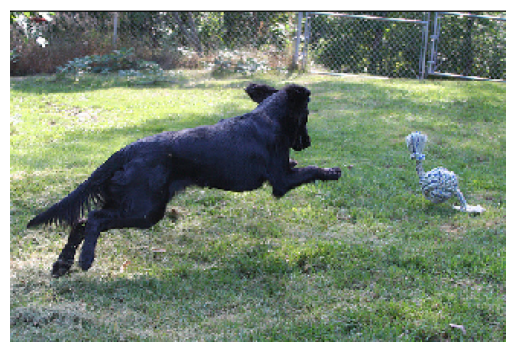

a <unk> <unk> in the background


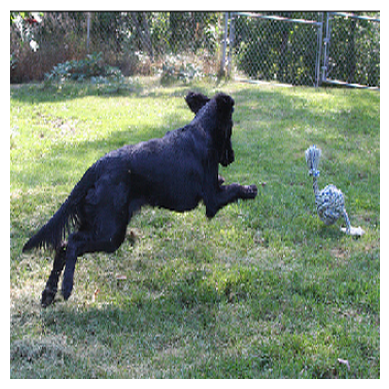

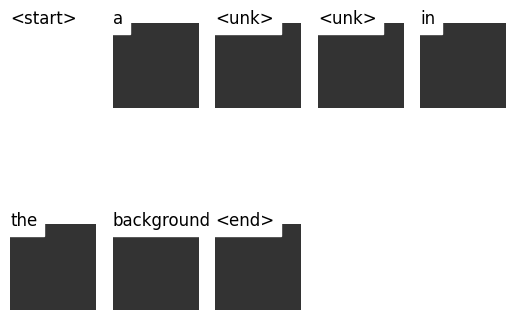

In [24]:
# Set the values of the variables according to your requirements
img_path = 'dog.png'

model_path = 'BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'  # model checkpoint
word_map_path = 'WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'  # word map, ensure it's the same the data was encoded with and the model was trained with

beam_size = 3
smooth = True

# Load model
checkpoint = torch.load(model_path, map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(word_map_path, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Encode, decode with attention and beam search
seq, alphas = caption_image_beam_search(encoder, decoder, img_path, word_map, beam_size)
alphas = torch.FloatTensor(alphas)

words = [rev_word_map[ind] for ind in seq]
print(' '.join(words[1:-1]))
image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

    #Visualize caption and attention of the best sequence
visualize_att(img_path, seq, alphas, rev_word_map, smooth)


a <unk> <unk> in the background


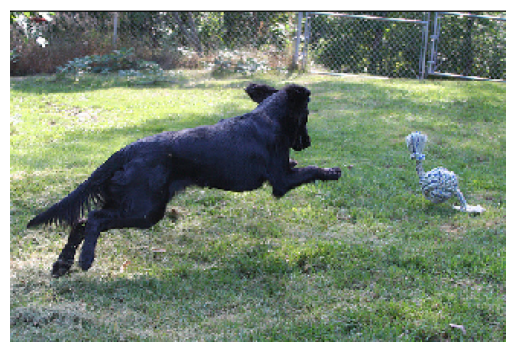

a <unk> <unk> in the background


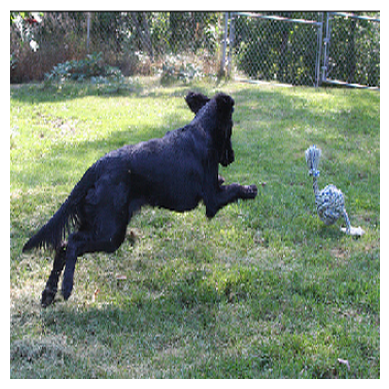

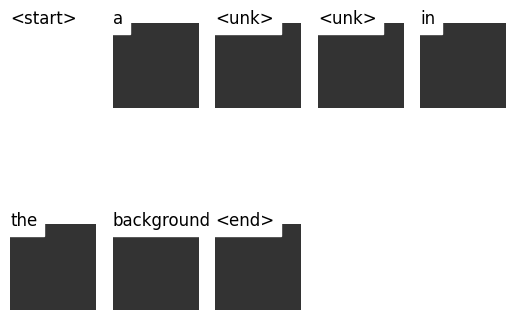

In [25]:
# Set the values of the variables according to your requirements
img_path = 'dog.png'

model_path = 'BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'  # model checkpoint
word_map_path = 'WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'  # word map, ensure it's the same the data was encoded with and the model was trained with

beam_size = 5
smooth = True

# Load model
checkpoint = torch.load(model_path, map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(word_map_path, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Encode, decode with attention and beam search
seq, alphas = caption_image_beam_search(encoder, decoder, img_path, word_map, beam_size)
alphas = torch.FloatTensor(alphas)

words = [rev_word_map[ind] for ind in seq]
print(' '.join(words[1:-1]))
image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

    #Visualize caption and attention of the best sequence
visualize_att(img_path, seq, alphas, rev_word_map, smooth)


a <unk> <unk> in the background


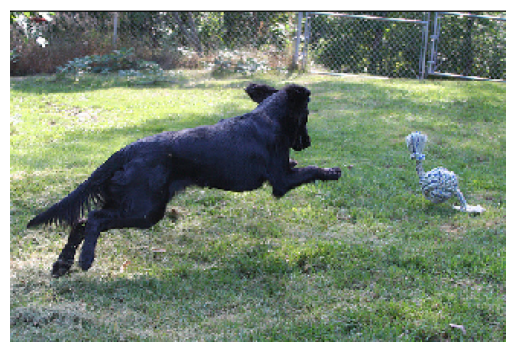

a <unk> <unk> in the background


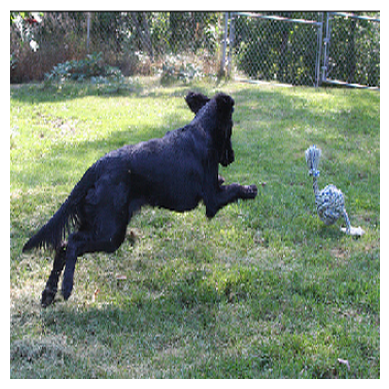

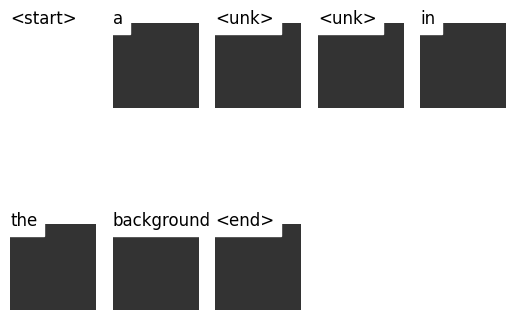

In [26]:
# Set the values of the variables according to your requirements
img_path = 'dog.png'

model_path = 'BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'  # model checkpoint
word_map_path = 'WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'  # word map, ensure it's the same the data was encoded with and the model was trained with

beam_size = 7
smooth = True

# Load model
checkpoint = torch.load(model_path, map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(word_map_path, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Encode, decode with attention and beam search
seq, alphas = caption_image_beam_search(encoder, decoder, img_path, word_map, beam_size)
alphas = torch.FloatTensor(alphas)

words = [rev_word_map[ind] for ind in seq]
print(' '.join(words[1:-1]))
image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

    #Visualize caption and attention of the best sequence
visualize_att(img_path, seq, alphas, rev_word_map, smooth)


a <unk> <unk>


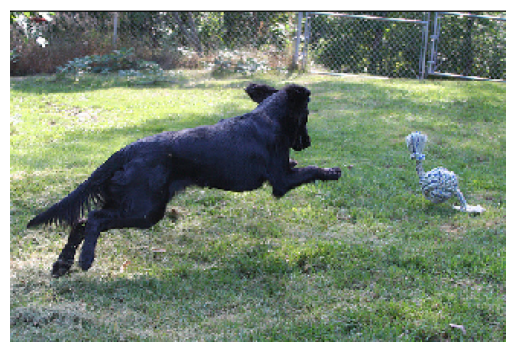

a <unk> <unk>


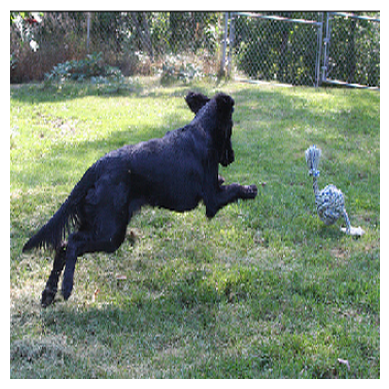

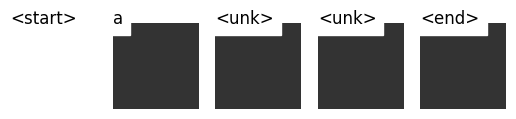

In [27]:
# Set the values of the variables according to your requirements
img_path = 'dog.png'

model_path = 'BEST_checkpoint_flickr8k_5_cap_per_img_5_min_word_freq.pth.tar'  # model checkpoint
word_map_path = 'WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'  # word map, ensure it's the same the data was encoded with and the model was trained with

beam_size = 9
smooth = True

# Load model
checkpoint = torch.load(model_path, map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(word_map_path, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Encode, decode with attention and beam search
seq, alphas = caption_image_beam_search(encoder, decoder, img_path, word_map, beam_size)
alphas = torch.FloatTensor(alphas)

words = [rev_word_map[ind] for ind in seq]
print(' '.join(words[1:-1]))
image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

    #Visualize caption and attention of the best sequence
visualize_att(img_path, seq, alphas, rev_word_map, smooth)


In [34]:
!sudo apt-get install build-essential -y
!pip install pycocoevalcap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dirmngr
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base gnupg gnupg-l10n
  gnupg-utils gpg-agent gpg-wks-client gpg-wks-server gpgsm
  libalgorithm-diff-perl libalgorithm-diff-xs-perl libalgorithm-merge-perl
  libasan5 libatomic1 libbinutils libcc1-0 libctf-nobfd0 libctf0 libdpkg-perl
  libfakeroot libfile-fcntllock-perl libgcc-9-dev libisl22 libitm1 libksba8
  liblocale-gettext-perl liblsan0 libmpc3 libmpfr6 libnpth0 libquadmath0
  libstdc++-9-dev libtsan0 libubsan1 make patch pinentry-curses xz-utils
Suggested packages:
  binutils-doc cpp-doc gcc-9-locales pinentry-gnome3 tor debian-keyring
  g++-multilib g++-9-multilib gcc-9-doc gcc-multilib manpages-dev autoconf
  automake libtool flex bison gdb gcc-doc gcc-9-multilib parcimonie xloadimage
  scdaemon bzr libstdc++-9-doc 

In [37]:
!pip install git+https://github.com/Maluuba/nlg-eval.git@master
!nlg-eval --setup


  Cloning https://github.com/Maluuba/nlg-eval.git (to revision master) to /tmp/pip-req-build-cz2hxtg4
  Running command git clone --filter=blob:none --quiet https://github.com/Maluuba/nlg-eval.git /tmp/pip-req-build-cz2hxtg4
  Resolved https://github.com/Maluuba/nlg-eval.git to commit 7f7993035a2f4729a15d20040fd904933ea58767
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.35-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 49.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 46.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 56.2 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.3 MB/s eta 0:00:00
  Created wheel for nlg-eval: filename=nlg_eval-2.3-py3-none-any.whl size=68175142 sh

In [43]:
!pip install pyciderevalcap

ERROR: Could not find a version that satisfies the requirement pyciderevalcap (from versions: none)
ERROR: No matching distribution found for pyciderevalcap


In [41]:
from nltk.translate.meteor_score import meteor_score
from cider import Cider
from pycocoevalcap.rouge import Rouge

def evaluate(beam_size):
    """
    Evaluation
    :param beam_size: beam size at which to generate captions for evaluation
    :return: BLEU-4, METEOR, ROUGE-L, CIDEr, and SPICE scores
    """
    # DataLoader
    loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TEST', transform=transforms.Compose([normalize])),
        batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

    # TODO: Batched Beam Search
    # Therefore, do not use a batch_size greater than 1 - IMPORTANT!

    # Lists to store references (true captions) and hypotheses (predictions) for each image
    references = []
    hypotheses = []

    # For each image
    for i, (image, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        # Rest of the code remains the same

        # ...

        if len(complete_seqs) > 0:
            i = complete_seqs_scores.index(max(complete_seqs_scores))
            seq = complete_seqs[i]
        else:
            seq = []

        # References
        img_caps = allcaps[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  # remove <start> and pads
        references.append(img_captions)

        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

        assert len(references) == len(hypotheses)

    # Calculate BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses)

    # Calculate METEOR score
    metrics = compute_metrics(references, hypotheses)
    meteor_scores = metrics['METEOR']

    # Calculate ROUGE-L score
    rouge_scores = metrics['ROUGE']

    # Calculate CIDEr score
    cider_scores = metrics['CIDEr']



    return bleu1,bleu2,bleu3, bleu4, meteor_scores, rouge_scores, cider_scores


ModuleNotFoundError: No module named 'cider'

In [ ]:
beam_size = 7
bleu1, bleu2, bleu3, bleu4, meteor_scores, rouge_scores, cider_scores, spice_scores = evaluate(beam_size)
print("\nBLEU-1 score @ beam size of %d is %.4f." % (beam_size, bleu1))
print("\nBLEU-2 score @ beam size of %d is %.4f." % (beam_size, bleu2))
print("\nBLEU-3 score @ beam size of %d is %.4f." % (beam_size, bleu3))
print("\nBLEU-4 score @ beam size of %d is %.4f." % (beam_size, bleu4))
print("\nmeteor score @ beam size of %d is %.4f." % (beam_size, meteor_scores))
print("\nrouge score @ beam size of %d is %.4f." % (beam_size, rouge_scores))
print("\cider score @ beam size of %d is %.4f." % (beam_size, cider_scores))